In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import random
import pandas as pd
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
from dataset import get_data
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = "../data/kaggle_data/"

In [4]:
# make dataset

def data_extract(df_dict, df, name, cols):
       for col in cols:
              df_dict[f"{name}_{col}"] = df.loc[df[col] != 0, col]
       return df_dict

train_data_list = []
val_data_list = []

pmj_df = pd.read_csv(DATA_PATH + "pjm_elec_daily.csv")
pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW'] # 'PJM_Load', 'EKPC'

df_dict = {}

df_dict = data_extract(df_dict, pmj_df, 'PMJ', pmj_cols)

for df_name in df_dict:
    df = df_dict[df_name]
    train_data, val_data, scaler = get_data(df, False)
    print(df_name, len(train_data), len(val_data))
    train_data_list.append((train_data, df_name, scaler))
    val_data_list.append((val_data, df_name, scaler))

PMJ_AEP 4044 1011
PMJ_COMED 2217 555
PMJ_DAYTON 4044 1011
PMJ_DEOK 1925 482
PMJ_DOM 3874 969
PMJ_DUQ 3970 993
PMJ_FE 2096 525
PMJ_NI 1949 488
PMJ_PJME 4847 1212
PMJ_PJMW 4775 1194


In [5]:
tmp_data, t, scaler = train_data_list[0]
tmp_data = pd.DataFrame(tmp_data)
tmp_data.head()

,0
0,328544.0
1,311997.0
2,293450.0
3,343417.0
4,346553.0


In [7]:
tmp_diff1 = tmp_data.diff().dropna()
tmp_diff1.head()

,0
1,-16547.0
2,-18547.0
3,49967.0
4,3136.0
5,-358.0


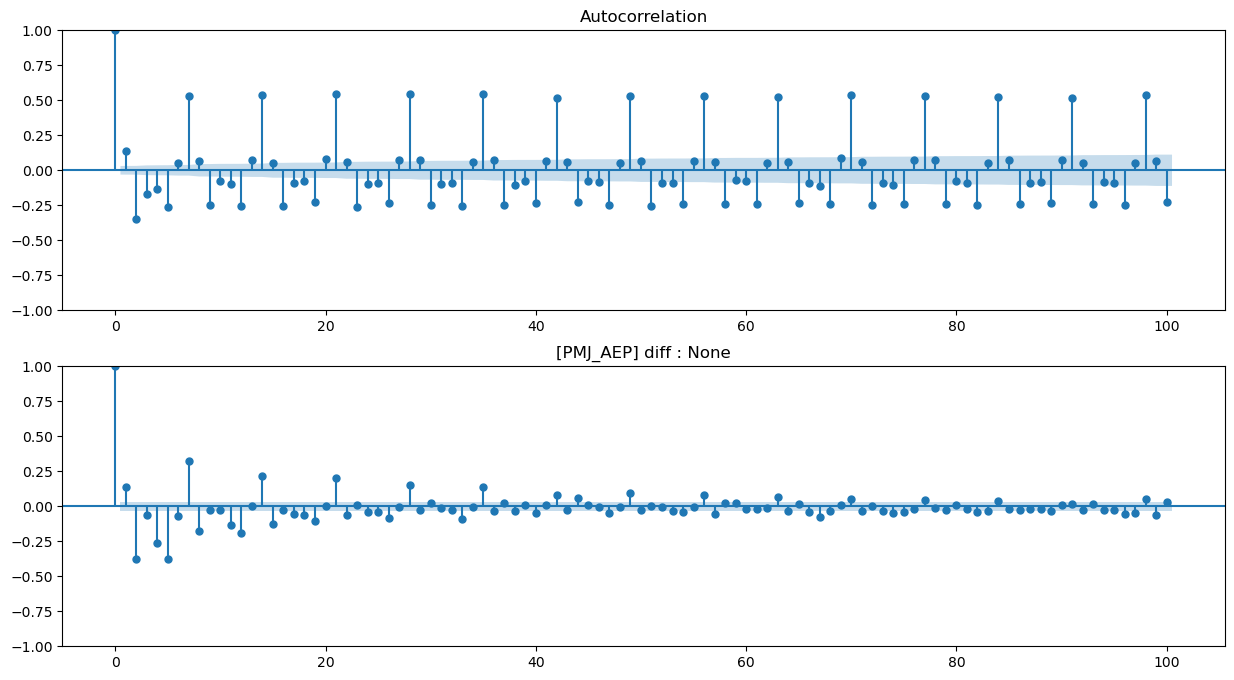

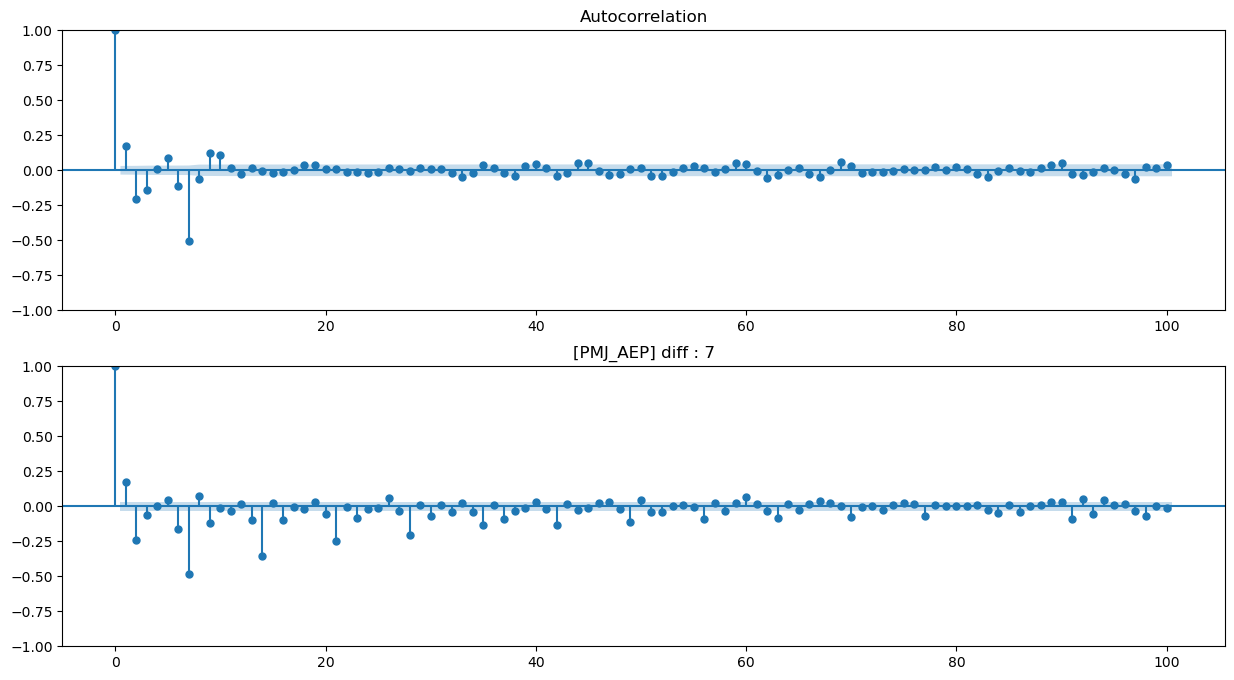

In [7]:
from util import plot_ac
diff = [7]

plot_ac(tmp_diff1, t, diff, data=False, acf=True, pacf=True, lags=100)

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(p, d, q)(P, D, Q, S)

orders = [(5, 7, 0)]
bset_AIC = float('inf')
for order in orders:
    model = ARIMA(tmp_diff1, order=order, seasonal_order=(0, 0, 0, 7))
    model_fit = model.fit()

    print(model_fit.summary())

    if bset_AIC > model_fit.aic:
        best_model = model_fit
        best_AIC = model_fit.aic

forecast = best_model.forecast(steps=10)

/Users/kwon/miniconda3/envs/arima/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kwon/miniconda3/envs/arima/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kwon/miniconda3/envs/arima/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                 4043
Model:                 ARIMA(5, 7, 0)   Log Likelihood              -54037.060
Date:                Thu, 16 May 2024   AIC                         108086.119
Time:                        18:55:13   BIC                         108123.937
Sample:                             0   HQIC                        108099.519
                               - 4043                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.7840      0.011   -252.777      0.000      -2.806      -2.762
ar.L2         -4.0317      0.026   -152.146      0.000      -4.084      -3.980
ar.L3         -3.7625      0.034   -111.385      0.0

/Users/kwon/miniconda3/envs/arima/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [10]:
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(tmp_data[-200:],
                              # start_p=3,
                              # start_q=3,
                              max_p=3,
                              max_q=3,
                              max_d=1,
                              seasonal=True,
                            #   start_P=3,
                            #   start_Q=3,
                              max_P=5,
                              max_Q=5,
                              D=0,
                              m=7,
                              max_order=15,
                              with_intercept='auto',
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False,
                              n_jobs=-1)

print(auto_arima_model.summary())

forecast = auto_arima_model.predict(n_periods=100)

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4574.240, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=4552.934, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=4545.318, Time=0.02 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=4546.031, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=4522.049, Time=0.02 sec
 ARIMA(0,1,0)(0,0,3)[7] intercept   : AIC=4541.349, Time=0.08 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=4523.901, Time=0.08 sec
 ARIMA(0,1,0)(0,0,4)[7] intercept   : AIC=4541.388, Time=0.16 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=4537.422, Time=0.04 sec
 ARIMA(0,1,0)(1,0,3)[7] intercept   : AIC=4525.547, Time=0.16 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=4523.826, Time=0.05 sec
 ARIMA(0,1,0)(0,0,5)[7] intercept   : AIC=4535.467, Time=0.31 sec
 ARIMA(0,1,0)(1,0,4)[7] intercept   : AIC=4527.532, Time=0.28 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=4524.439, Time=0.13 sec
 ARIMA(0,1,0)(3,0,0)[7] intercept   : AIC=4532.477, Time=0.07 sec
 ARIMA(0,1

4044    327817.376258
4045    324407.983459
4046    318142.455015
4047    300016.025927
4048    295102.640799
            ...      
4139    207354.440829
4140    221242.756209
4141    221660.527120
4142    218081.227614
4143    216176.310402
Length: 100, dtype: float64


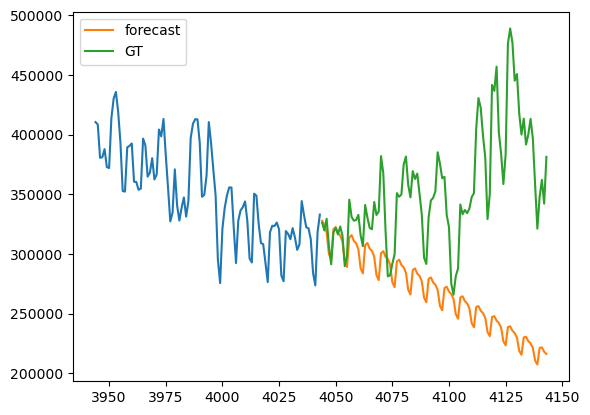

In [11]:
import matplotlib.pyplot as plt

print(forecast)
plt.plot(tmp_data[-100:])
plt.plot(forecast, label='forecast')
plt.plot(list(forecast.index), val_data_list[0][0][:len(forecast)], label='GT')
plt.legend()
plt.show()